In [1]:
import transformers
import torch
import pandas as pd
import nltk
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_metric, Dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split

In [2]:
rouge_score = evaluate.load("rouge")

In [3]:
from openpyxl import load_workbook
wb = pd.read_excel('./DATASET.xlsx', 0)
wb.head()

,База данных,Текстовый запрос,Токен текстовый запрос,Запрос SQL,Токен запрос SQL
0,отдел_управления,"""How many heads of the departments are older t...","[ ""How"", ""many"", ""heads"", ""of"", ""the"", ""depart...","""SELECT count(*) FROM head WHERE age > 56""","[ ""SELECT"", ""count"", ""("", ""*"", "")"", ""FROM"", ""h..."
1,отдел_управления,"""List the name, born state and age of the head...","[ ""List"", ""the"", ""name"", "","", ""born"", ""state"",...","""SELECT name , born_state , age FROM head ORDE...","[ ""SELECT"", ""name"", "","", ""born_state"", "","", ""a..."
2,отдел_управления,"""List the creation year, name and budget of ea...","[ ""List"", ""the"", ""creation"", ""year"", "","", ""nam...","""SELECT creation , name , budget_in_billions F...","[ ""SELECT"", ""creation"", "","", ""name"", "","", ""bud..."
3,отдел_управления,"""What are the maximum and minimum budget of th...","[ ""What"", ""are"", ""the"", ""maximum"", ""and"", ""min...","""SELECT max(budget_in_billions) , min(budget_i...","[ ""SELECT"", ""max"", ""("", ""budget_in_billions"", ..."
4,отдел_управления,"""What is the average number of employees of th...","[ ""What"", ""is"", ""the"", ""average"", ""number"", ""o...","""SELECT avg(num_employees) FROM department WHE...","[ ""SELECT"", ""avg"", ""("", ""num_employees"", "")"", ..."


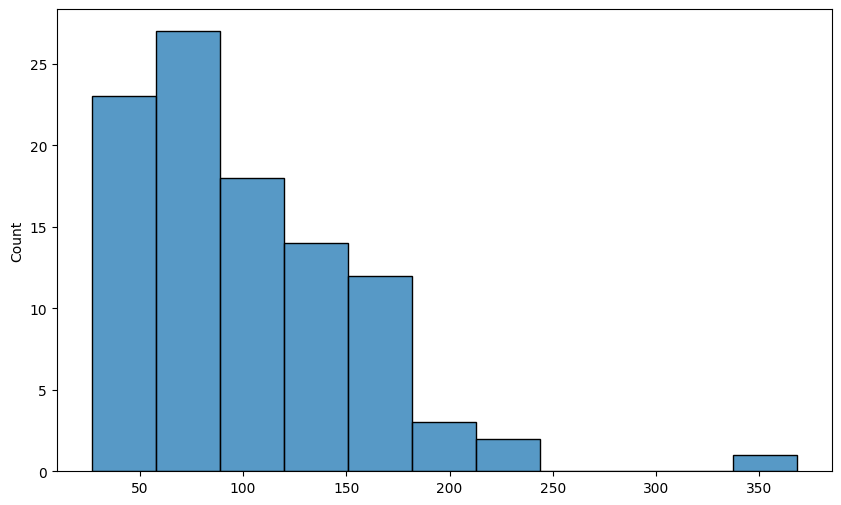

In [4]:
l = []
for i in wb['Запрос SQL']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.histplot(l)
plt.show()

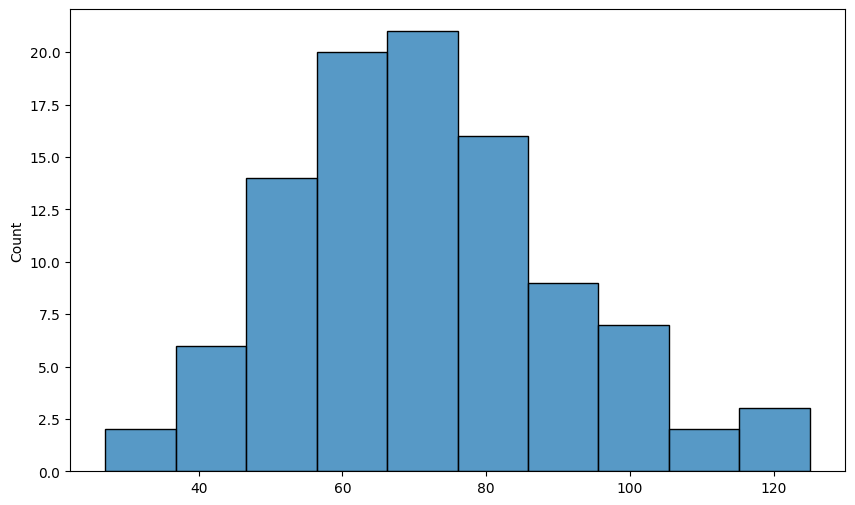

In [5]:
l = []
for i in wb['Текстовый запрос']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.histplot(l)
plt.show()

In [6]:
wb = wb[['Запрос SQL','Текстовый запрос']]

In [7]:
train_df, val_df = train_test_split(wb,test_size = 0.1, random_state = 21)
print(train_df.shape)
print(val_df.shape)

(90, 2)
(10, 2)


In [8]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['Запрос SQL', 'Текстовый запрос'],
    num_rows: 90
})
Dataset({
    features: ['Запрос SQL', 'Текстовый запрос'],
    num_rows: 10
})


In [9]:
train_dataset['Запрос SQL'][1]

'"SELECT T1.student_details FROM students AS T1 JOIN student_course_registrations AS T2 ON T1.student_id = T2.student_id GROUP BY T1.student_id ORDER BY count(*) DESC LIMIT 1"'

In [10]:
# downloading model from the checkpoint
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
)

tokenizer = T5Tokenizer.from_pretrained('CheesyPitsa/5chobanov')
#МОДЕЛЬ-------------------------------------------------------------------------------
model_checkpoint = T5ForConditionalGeneration.from_pretrained('CheesyPitsa/5chobanov')
tokenizer.save_pretrained("./bigscience_t0")
model_checkpoint.save_pretrained("./bigscience_t0")

In [11]:
max_input_length = 256
max_target_length = 256


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['Текстовый запрос'],
        max_length=max_input_length,
        truncation=True, padding = 'max_length'
    )
    labels = tokenizer(text = examples['Запрос SQL'], max_length=max_target_length, truncation=True,padding = 'max_length')
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels_mask"] = labels["attention_mask"]
    return model_inputs

In [12]:
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True)
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['Запрос SQL','Текстовый запрос'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['Запрос SQL','Текстовый запрос'])

In [14]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
model = AutoModelForSeq2SeqLM.from_pretrained("./bigscience_t0")

In [15]:
data_collator = DataCollatorForSeq2Seq(model = model,tokenizer = tokenizer,label_pad_token_id=-100)

In [16]:
batch_size = 8
learning_rate = 1e-5
args = Seq2SeqTrainingArguments(
    "test-summary",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    push_to_hub = False,
    report_to = "all"
)

In [17]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [18]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: labels_mask. If labels_mask are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 90
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36
  Number of trainable parameters = 60506624


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.999933,0.465100,0.000000,0.465100,0.465100
2,No log,0.968817,0.465100,0.000000,0.465100,0.465100
3,No log,0.962270,0.000000,0.000000,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: labels_mask. If labels_mask are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: labels_mask. If labels_mask are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: labels_mask. If labels_mask are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10
  Batch size = 

TrainOutput(global_step=36, training_loss=2.4555611080593533, metrics={'train_runtime': 481.4292, 'train_samples_per_second': 0.561, 'train_steps_per_second': 0.075, 'total_flos': 18271143198720.0, 'train_loss': 2.4555611080593533, 'epoch': 3.0})

In [20]:
from huggingface_hub import notebook_login

In [21]:
notebook_login()

In [22]:
model.save_pretrained('CheesyPitsa/5chobanov',push_to_hub=True)
tokenizer.save_pretrained('CheesyPitsa/5chobanov',push_to_hub=True)

Configuration saved in CheesyPitsa/5chobanov\config.json
Model weights saved in CheesyPitsa/5chobanov\pytorch_model.bin
Uploading the following files to CheesyPitsa/5chobanov: config.json,pytorch_model.bin
tokenizer config file saved in CheesyPitsa/5chobanov\tokenizer_config.json
Special tokens file saved in CheesyPitsa/5chobanov\special_tokens_map.json
Uploading the following files to CheesyPitsa/5chobanov: special_tokens_map.json,tokenizer_config.json


('CheesyPitsa/5chobanov\\tokenizer_config.json',
 'CheesyPitsa/5chobanov\\special_tokens_map.json',
 'CheesyPitsa/5chobanov\\spiece.model',
 'CheesyPitsa/5chobanov\\added_tokens.json')